In [ ]:
%pip install -U langgraph "langchain[openai]" langchain-community langchain-text-splitters chromadb

In [10]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore  # or Qdrant, Chroma
# from langchain_openai import OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools.retriever import create_retriever_tool
from dotenv import load_dotenv
from IPython.display import Image, display
import os
load_dotenv(override=True)

True

In [11]:
# Gemini for reasoning/answer generation
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001",google_api_key=os.getenv('GEMINI_ACCESS_KEY'))  # or "gemini-1.5-pro"

# Gemini embeddings for vector store
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001",google_api_key=os.getenv('GEMINI_ACCESS_KEY'))

In [12]:
urls = [
    "https://python.langchain.com/docs/",
    "https://qdrant.tech/documentation/",
    "https://blog.langchain.com/agentic-rag-with-langgraph/"
]

In [15]:
# Load & split
# docs = [WebBaseLoader(url).load()[0] for url in urls]
docs = []
for url in urls:
    loaded = WebBaseLoader(url).load()
    docs.extend(loaded) 

docs_list = docs
splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000, chunk_overlap=50)
# splits = splitter.split_documents(docs_list)
splits = splitter.split_documents(docs)

# Extract only text from the documents
texts = [doc.page_content for doc in splits]

# Now embed only the text
vectorstore = InMemoryVectorStore.from_texts(texts, embedding=embeddings)
retriever = vectorstore.as_retriever()
retriever_tool = create_retriever_tool(retriever, "retrieve", "Retrieve relevant docs.")
# tool=[retriever_tool]
# llm_with_tools=llm.bind_tools(tool)

In [16]:
def decide_to_generate(state):
    """
    Looks at the document grading results in the state.
    Returns which edge to follow.
    """
    # Suppose state["documents"] contains a list of (doc, relevance_score)
    grades = state.get("doc_grades", [])

    if all(grade == "relevant" for grade in grades):
        return "generate_answer"
    else:
        return "rewrite_query"


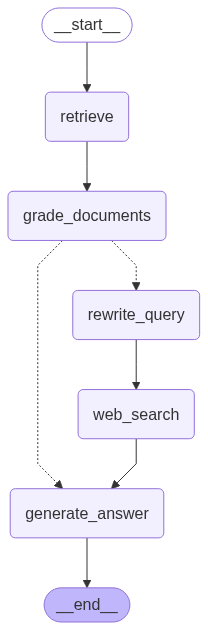

In [35]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# --- Define State ---
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Use retriever inside the node
def retrieve(state: State):
    print("🔎 retrieving docs...")
    last_message = state["messages"][-1]
    # If last_message is a dict, extract the content
    if isinstance(last_message, dict):
        query = last_message.get("content", "")
    else:
        query = last_message
    # Ensure query is a string
    if not isinstance(query, str):
        query = str(query)
    docs = retriever.get_relevant_documents(query)
    state["retrieved_docs"] = docs
    return {"messages": state["messages"] + [f"Retrieved {len(docs)} docs"]}


# Grade docs (simple heuristic for now)
def grade_documents(state: State):
    print("📝 grading docs...")
    if state.get("retrieved_docs"):
        state["doc_grades"] = ["relevant"] * len(state["retrieved_docs"])
    else:
        state["doc_grades"] = ["irrelevant"]
    return {"messages": state["messages"] + ["Docs graded"]}

# Generate final answer using Gemini
def generate_answer(state: State):
    print("💡 generating final answer with Gemini...")
    query = state["messages"][0]  # original user query
    docs = state.get("retrieved_docs", [])
    context = "\n\n".join(d.page_content for d in docs)
    prompt = f"Answer the question: {query}\n\nContext:\n{context}"
    
    response = llm.invoke(prompt)   # <-- here Gemini is called
    return {"messages": state["messages"] + [response.content]}




def rewrite_query(state: State):
    print("🔄 rewriting query...")
    return {"messages": state["messages"] + ["rewritten query"]}

def web_search(state: State):
    print("🌍 doing web search...")
    return {"messages": state["messages"] + ["searched web"]}

# --- Build graph ---
agentic_rag = StateGraph(State)

# Register all nodes
agentic_rag.add_node("retrieve", retrieve)
agentic_rag.add_node("grade_documents", grade_documents)
agentic_rag.add_node("rewrite_query", rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer", generate_answer)

# Wire edges
agentic_rag.set_entry_point("retrieve")  # or agentic_rag.add_edge(START, "retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer": "generate_answer"}
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

# Compile graph
app = agentic_rag.compile()
display(Image(app.get_graph().draw_mermaid_png()))

# # --- Run ---
# result = app.invoke({"messages": ["What is Agentic RAG?"]})
# print("Result:", result)


In [38]:
result = app.invoke({"messages": [{"role": "user", "content": "What is Agentic langGraph?"}]})
print(result["messages"][-1].content)

🔎 retrieving docs...
📝 grading docs...
💡 generating final answer with Gemini...
Agentic LangGraph is a framework built on top of LangChain that makes it easier to create complex, stateful, multi-agent workflows. It allows you to define a graph where each node represents an agent (or other function), and the edges represent the flow of information between them.  Crucially, LangGraph maintains a state that is passed between these agents, allowing them to build upon each other's work and make decisions based on the entire history of the interaction. This statefulness is key to creating more sophisticated and reliable agentic workflows compared to simpler chained approaches.

Here's a breakdown of what makes it important:

*   **Stateful Agent Orchestration:** LangGraph centers around the idea of a state that evolves as agents interact. This state can contain information gathered from previous steps, agent outputs, and other relevant data. This shared context allows agents to reason about 

In [37]:
result = app.invoke({"messages": [{"role": "user", "content": "What is grpc?"}]})
print(result["messages"][-1].content)

🔎 retrieving docs...
📝 grading docs...
💡 generating final answer with Gemini...
gRPC (gRPC Remote Procedure Call) is a modern, open-source, high-performance remote procedure call (RPC) framework.  It's designed to connect services together and is particularly well-suited for:

*   **Microservices Architectures:** gRPC excels in microservices environments, enabling efficient communication between different services.
*   **Mobile Applications:**  It's optimized for low-power devices and unreliable networks, making it suitable for communication between mobile apps and backend services.
*   **Browser-to-Backend Communication:** While traditionally more complex, gRPC-Web allows browsers to communicate with gRPC backends.
*   **Polyglot Environments:** gRPC supports multiple programming languages, making it possible to build services in different languages and have them communicate seamlessly.

**Key characteristics of gRPC:**

*   **Protocol Buffers (protobuf):** gRPC uses protocol buffers 

In [36]:
result = app.invoke({"messages": [{"role": "user", "content": "What is Self RAG?"}]})
print(result["messages"][-1].content)

🔎 retrieving docs...
📝 grading docs...
💡 generating final answer with Gemini...
Please provide the context! I need the context to answer the question "What is Self RAG?" effectively. I will use the context to give you a comprehensive and relevant answer.
